# ML Models and Performance
This notebook contains 5 models and their performance (accuracy, precision, recall, F1 score in Table 3 of the paper) as well as UMAP embedding and visualization (Figure 5 in the paper) based on the same model features.

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import umap
from matplotlib import pyplot as plt
import xgboost as xgb

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import SMOTE

import con_score

### Data Prep

In [36]:
df = pd.read_csv('../output/Chess.com/final_df_min10.csv')

In [37]:
df['game_id'] = df['day'].astype(str) + df['month'] + df['year'].astype(str) 
df['winner'] = df.apply(lambda x: x['white_username'] if x['white_result'] == 1 else x['black_username'], axis=1)
df['loser'] = df.apply(lambda x: x['black_username'] if x['white_result'] == 0 else x['white_username'], axis=1)

In [38]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

In [39]:
df['date'] = df['month'] + df['year'].astype(str) 

In [40]:
df.game_id.nunique(), df.date.nunique()

(53, 12)

### CON Function

In [41]:
try:
    con_scores_df = pd.read_csv('../output/Chess.com/con_scores_df.csv')
except:
    con_scores_df = con_score.calculate_CON_multiorder1(df)
    con_scores_df.to_csv('../output/Chess.com/con_scores_df.csv', index=False)

In [42]:
con_scores_df.shape

(43034, 10)

In [43]:
con_scores_df_1st = con_scores_df.groupby(['player', 'date']).agg({'1st_order_CON_score': 'sum'}).reset_index()
con_scores_df_2nd = con_scores_df.groupby(['player', 'date']).agg({'2nd_order_CON_score': 'sum'}).reset_index()
con_scores_df_lrg = con_scores_df.groupby(['player', 'date']).agg({'full_CON_score': 'sum'}).reset_index()
con_scores_df_pr = con_scores_df.groupby(['player', 'date']).agg({'pagerank': 'sum'}).reset_index()
con_scores_df_cn = con_scores_df.groupby(['player', 'date']).agg({'closeness': 'sum'}).reset_index()
con_scores_df_id = con_scores_df.groupby(['player', 'date']).agg({'in_degree': 'sum'}).reset_index()
con_scores_df_od = con_scores_df.groupby(['player', 'date']).agg({'out_degree': 'sum'}).reset_index()

In [44]:
con_matrix_1st = con_scores_df_1st.pivot(index='player', columns='date', values='1st_order_CON_score')
con_matrix_1st.columns = [f"1storder_{col}" for col in con_matrix_1st.columns]
con_matrix_1st = con_matrix_1st.fillna(0)

con_matrix_2nd = con_scores_df_2nd.pivot(index='player', columns='date', values='2nd_order_CON_score')
con_matrix_2nd.columns = [f"2ndorder_{col}" for col in con_matrix_2nd.columns]
con_matrix_2nd = con_matrix_2nd.fillna(0)

con_matrix_lrg = con_scores_df_lrg.pivot(index='player', columns='date', values='full_CON_score')
con_matrix_lrg.columns = [f"CON_{col}" for col in con_matrix_lrg.columns]
con_matrix_lrg = con_matrix_lrg.fillna(0)

pr_matrix = con_scores_df_pr.pivot(index='player', columns='date', values='pagerank')
pr_matrix.columns = [f"pagerank_{col}" for col in pr_matrix.columns]
pr_matrix = pr_matrix.fillna(0)

cn_matrix = con_scores_df_cn.pivot(index='player', columns='date', values='closeness')
cn_matrix.columns = [f"closeness_{col}" for col in cn_matrix.columns]
cn_matrix = cn_matrix.fillna(0)

id_matrix = con_scores_df_id.pivot(index='player', columns='date', values='in_degree')
id_matrix.columns = [f"indegree_{col}" for col in id_matrix.columns]
id_matrix = id_matrix.fillna(0)

od_matrix = con_scores_df_od.pivot(index='player', columns='date', values='out_degree')
od_matrix.columns = [f"outdegree_{col}" for col in od_matrix.columns]
od_matrix = od_matrix.fillna(0)

In [45]:
con_matrix_2nd = con_matrix_2nd.reindex(con_matrix_1st.index)
con_matrix_lrg = con_matrix_lrg.reindex(con_matrix_1st.index)
pr_matrix = pr_matrix.reindex(con_matrix_1st.index)
cn_matrix = cn_matrix.reindex(con_matrix_1st.index)
od_matrix = od_matrix.reindex(con_matrix_1st.index)
id_matrix = id_matrix.reindex(con_matrix_1st.index)

In [46]:
combined_matrix = pd.concat([con_matrix_1st, con_matrix_2nd, con_matrix_lrg, 
                             pr_matrix, cn_matrix, od_matrix, id_matrix
                             ], axis=1)
matrix_df_combined = combined_matrix.reset_index()

In [47]:
matrix_df_combined.shape

(2371, 372)

In [48]:
X = matrix_df_combined.iloc[:, 1:].to_numpy()

### Create Labels

In [49]:
elo_dict = pd.read_pickle('../output/Chess.com/elo_dict.pkl')

In [50]:
elo_df = pd.DataFrame.from_dict(elo_dict, orient='index', columns=['elo']).reset_index().rename(columns={'index': 'player'})

In [51]:
matrix_df_combined.player.nunique(), elo_df.player.nunique()

(2371, 2371)

In [52]:
elo_df = elo_df.sort_values('player')

In [53]:
quantiles = [0, 0.1, 0.9, 1]
elo_df['elo_quantile'] = pd.qcut(elo_df['elo'], q=quantiles, labels=False)
elo_quantile_counts = elo_df.value_counts('elo_quantile')
y = np.array(elo_df['elo_quantile'].astype(int))
print(elo_quantile_counts)

elo_quantile
1    1896
0     239
2     236
Name: count, dtype: int64


In [54]:
np.bincount(y)

array([ 239, 1896,  236], dtype=int64)

### Split Data

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 

In [56]:
np.bincount(y_train)

array([ 167, 1327,  165], dtype=int64)

### SMOTE

In [57]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [58]:
np.bincount(y_train_smote)

array([1327, 1327, 1327], dtype=int64)

### Train ML Models

In [59]:
models = {
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=42),
    "SupportVectorClassifier-LINEAR": SVC(random_state=42),
    "XGBClassifier": xgb.XGBClassifier(random_state=42),
}

results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

predictions = []
for name, model in tqdm(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    predictions.append(y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("Bin Counts: ", np.bincount(y_pred))
    print("\n")

    results["Model"].append(name)
    results["Accuracy"].append(accuracy)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1-Score"].append(f1)

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 20%|██        | 1/5 [00:14<00:57, 14.45s/it]

Model: GradientBoostingClassifier
Accuracy: 0.797752808988764
Precision: 0.429771955361475
Recall: 0.3820556614437651
F1-Score: 0.37845010615711255
Bin Counts:  [  0 687  25]




 40%|████      | 2/5 [00:14<00:18,  6.15s/it]

Model: DecisionTreeClassifier
Accuracy: 0.651685393258427
Precision: 0.3786312145626247
Recall: 0.3862222020530394
F1-Score: 0.3816661236016075
Bin Counts:  [ 82 547  83]




C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 60%|██████    | 3/5 [00:15<00:07,  3.80s/it]

Model: RandomForestClassifier
Accuracy: 0.7991573033707865
Precision: 0.4356388088376561
Recall: 0.37031444672722924
F1-Score: 0.36300823495571155
Bin Counts:  [  0 694  18]




C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
 80%|████████  | 4/5 [00:16<00:02,  2.43s/it]

Model: SupportVectorClassifier-LINEAR
Accuracy: 0.7991573033707865
Precision: 0.2663857677902622
Recall: 0.3333333333333333
F1-Score: 0.2961228207129846
Bin Counts:  [  0 712]




100%|██████████| 5/5 [00:17<00:00,  3.60s/it]

Model: XGBClassifier
Accuracy: 0.7879213483146067
Precision: 0.43759972540725073
Recall: 0.35323561822670707
F1-Score: 0.3416666666666666
Bin Counts:  [  8 691  13]




In [60]:
np.bincount(predictions[2])

array([  0, 694,  18], dtype=int64)

In [61]:
results = pd.DataFrame(results)
display(results.sort_values('Accuracy', ascending=False))

,Model,Accuracy,Precision,Recall,F1-Score
2,RandomForestClassifier,0.799157,0.435639,0.370314,0.363008
3,SupportVectorClassifier-LINEAR,0.799157,0.266386,0.333333,0.296123
0,GradientBoostingClassifier,0.797753,0.429772,0.382056,0.378450
4,XGBClassifier,0.787921,0.437600,0.353236,0.341667
1,DecisionTreeClassifier,0.651685,0.378631,0.386222,0.381666


In [62]:
results.to_csv("../output/Chess.com/Chess_CON_score_ML_results.csv")

### UMAP Visualization

In [63]:
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=75, spread=15, min_dist=0.5,metric='euclidean')
embedding = umap_reducer.fit_transform(X, y=y)

C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1394: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
C:\Users\walaa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


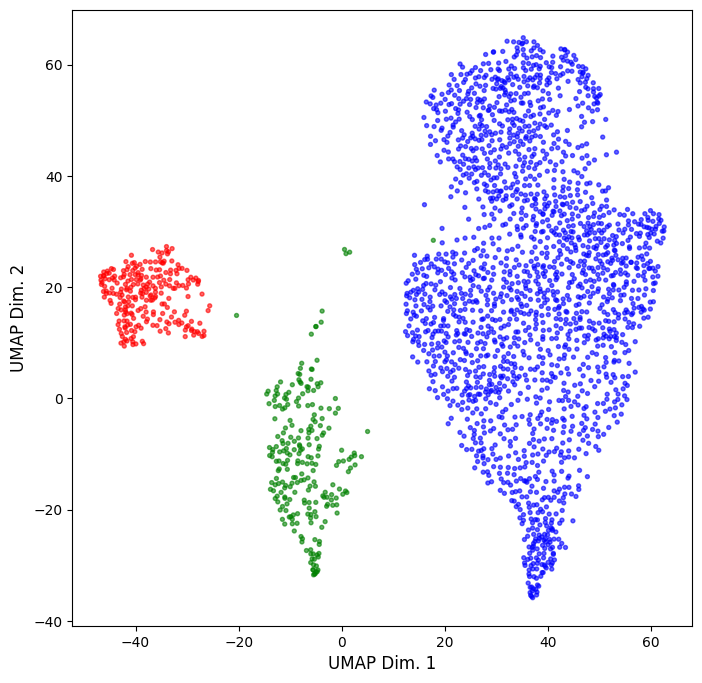

In [64]:
plt.figure(figsize=(8, 8))
color_map = {0: 'red', 1: 'blue', 2: 'green'}
colors = [color_map[label] for label in y]
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=colors,  s=8, alpha=0.6)
plt.xlabel("UMAP Dim. 1", fontsize=12)
plt.ylabel("UMAP Dim. 2", fontsize=12)
plt.savefig("../output/Chess.com/Chess_CON_UMAP.eps", format='eps')
plt.show()

#### Feature Importance

In [65]:
model = models['RandomForestClassifier']
feature_names = matrix_df_combined.iloc[:, 1:].columns
feature_importance = pd.DataFrame({'Feature': feature_names,  'Importance': model.feature_importances_}).sort_values(by='Importance', ascending=False)
feature_importance['Feature_Group'] = feature_importance['Feature'].str.split('_').str[0]
aggregated_importance = feature_importance.groupby('Feature_Group', as_index=False)['Importance'].sum()
aggregated_importance = aggregated_importance.sort_values(by='Importance', ascending=False)
display(aggregated_importance)

,Feature_Group,Importance
6,pagerank,0.168434
1,2ndorder,0.162329
3,closeness,0.161947
2,CON,0.161606
0,1storder,0.145491
4,indegree,0.103323
5,outdegree,0.096869


In [66]:
max_importance = feature_importance.groupby('Feature_Group', as_index=False)['Importance'].max()
max_importance = max_importance.sort_values(by='Importance', ascending=False)
display(max_importance)

,Feature_Group,Importance
1,2ndorder,0.006870
2,CON,0.005872
6,pagerank,0.005410
0,1storder,0.005279
3,closeness,0.005242
4,indegree,0.003140
5,outdegree,0.002791


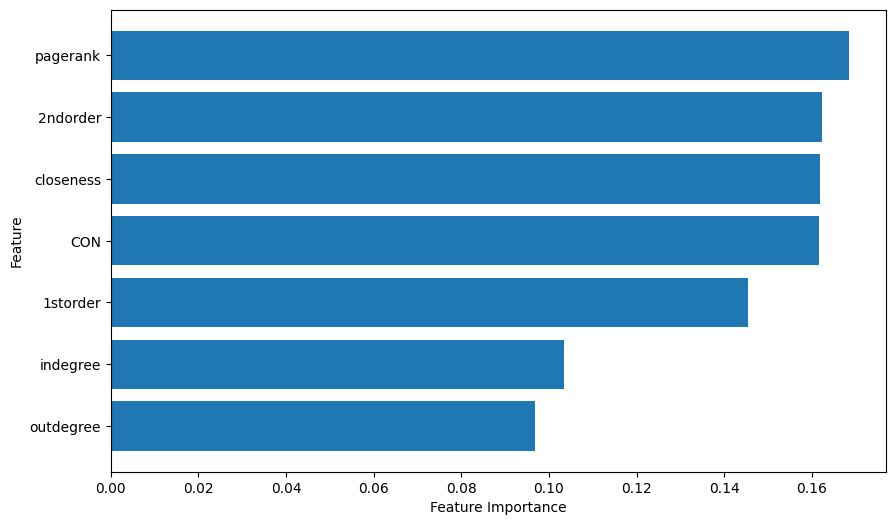

In [67]:
plt.figure(figsize=(10, 6))
plt.barh(aggregated_importance['Feature_Group'], aggregated_importance['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis() 
plt.savefig("../output/Chess.com/Chess.com_fi_bar_plot.svg", format='svg')
plt.show()

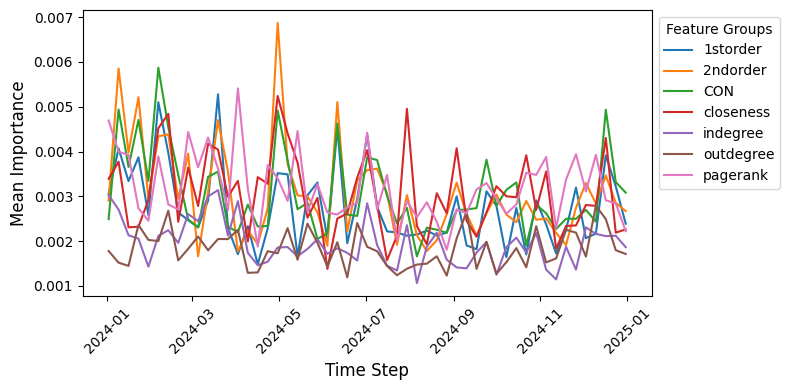

In [68]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importance['Feature_Group'] = feature_importance['Feature'].str.split('_').str[0]
feature_importance['Time_Step'] = feature_importance['Feature'].str.split('_').str[1]

feature_importance['Time_Step'] = pd.to_datetime(feature_importance['Time_Step'], format='%d%B%Y', errors='coerce')
feature_importance = feature_importance.dropna(subset=['Time_Step'])
group_time_mean_importance = feature_importance.groupby(['Feature_Group', 'Time_Step'], as_index=False)['Importance'].mean()

time_step_importance = group_time_mean_importance.pivot(
    index='Time_Step', columns='Feature_Group', values='Importance'
)

time_step_importance = time_step_importance.sort_index()

plt.figure(figsize=(8, 4))
for group in time_step_importance.columns:
    plt.plot(time_step_importance.index, time_step_importance[group], label=group)

plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Mean Importance', fontsize=12)
plt.xticks(rotation=45)  
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Feature Groups")
plt.grid(False)
plt.tight_layout()
plt.savefig("../output/Chess.com/Chess.com_fi_time_plot.svg", format='svg')
plt.show()